In [1]:
# Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sqlite3

Using Pandas, open all the dataframes (CSV,TSV,SQL)

In [3]:
# Read in Dataframes

In [4]:
grossdf = pd.read_csv('../../data/bom.movie_gross.csv.gz')
#grossdf.head(5)

In [5]:
ratingdf = pd.read_csv('../../data/rt.movie_info.tsv.gz', sep='\t')
#ratingdf

In [6]:
reviewdf = pd.read_csv('../../data/rt.reviews.tsv.gz', sep='\t', encoding='iso-8859-1')
#reviewdf.head(5)

In [7]:
tmdbmoviesdf = pd.read_csv('../../data/tmdb.movies.csv.gz')
#tmdbmoviesdf.head(5)

In [8]:
budgetdf = pd.read_csv('../../data/tn.movie_budgets.csv.gz')
#budgetdf.head(5)

In [9]:
import zipfile
import os

In [10]:
# open the zip file
with zipfile.ZipFile('../../data/im.db.zip', 'r') as zip_ref:
    # extract the database file
    print('Extracting im.db file...')
    zip_ref.extract('im.db')
    print('im.db file extracted successfully.')
    
# check if the file exists
if os.path.isfile('im.db'):
    print('im.db file exists.')
else:
    print('im.db file does not exist.')

# connect to the database
conn = sqlite3.connect('im.db')

# read a SQL query into a pandas dataframe
df = pd.read_sql('SELECT * FROM movie_basics', conn)

# print the dataframe
#df

Extracting im.db file...
im.db file extracted successfully.
im.db file exists.


In [11]:
# Get a quick snapshot of how the dataframe looks
#grossdf.head()

In [12]:
#grossdf.info()

In [13]:
# Get a quick snapshot of how the dataframe looks
#df.head()

In [14]:
#df.info()

Rename the column in the SQL dataframe from original_title to title so column matches other dataframe that it is going to be merged with

In [15]:
# Rename the column
df.rename(columns={'original_title':'title'}, inplace=True)

In [16]:
# Merge the two dataframes on the title column
merged = pd.merge(df, grossdf, on='title')
merged.drop_duplicates(subset='title', inplace=True)

In [17]:
# Group merged dataframe by genres and show the mean domestic gross revenue
groupeddf = merged.groupby('genres')['domestic_gross'].mean()

In [18]:
# Find the top 10 genres based off gross revenue
top10domesticgross = groupeddf.nlargest(10)
#top10domesticgross

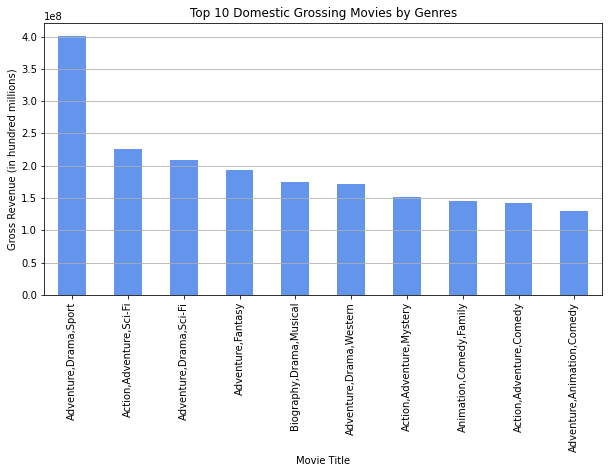

In [19]:
# Create a barplot to show the difference in top 10
# Set figure size
plt.figure(figsize=(10, 5))

# Plot data
top10domesticgross.plot(kind='bar', color='cornflowerblue')

# Add title and axis labels
plt.title('Top 10 Domestic Grossing Movies by Genres')
plt.xlabel('Movie Title')
plt.ylabel('Gross Revenue (in hundred millions)')

# Add grid lines
plt.grid(axis='y')


# Show plot
plt.show()

<AxesSubplot:ylabel='Frequency'>

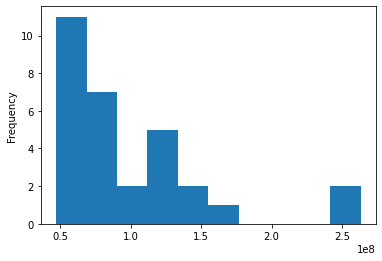

In [20]:
# Group merged dataframe by runtime and show the mean domestic gross revenue
groupeddf2_runtime = merged.groupby('runtime_minutes')['domestic_gross'].mean()
top30runtime = groupeddf2_runtime.nlargest(30)
top30runtime.plot.hist()

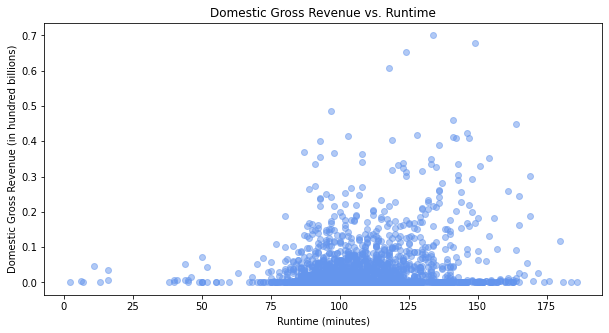

In [21]:
# Set figure size
plt.figure(figsize=(10, 5))

# Create scatter plot
plt.scatter(merged['runtime_minutes'], merged['domestic_gross']/1e9, alpha=0.5, color='cornflowerblue')

# Add title and axis labels
plt.title('Domestic Gross Revenue vs. Runtime')
plt.xlabel('Runtime (minutes)')
plt.ylabel('Domestic Gross Revenue (in hundred billions)')

# Show plot
plt.show()

In [22]:
merged2 = pd.merge(grossdf,tmdbmoviesdf , on='title')
merged2.drop_duplicates(subset='title', inplace=True)

In [23]:
#merged2

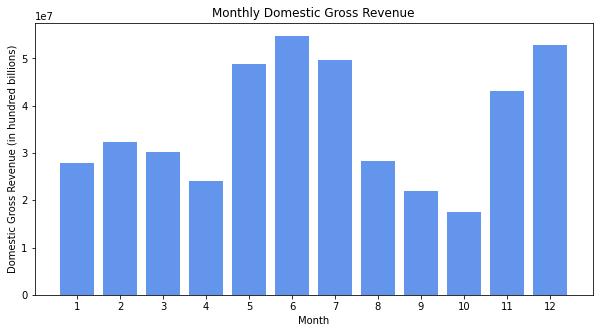

In [24]:
# Convert release_date column to datetime format
merged2['release_date'] = pd.to_datetime(merged2['release_date'])

# Extract month from release_date column
merged2['month'] = merged2['release_date'].dt.month

# Group data by month and calculate mean domestic gross revenue
monthly_gross = merged2.groupby('month')['domestic_gross'].mean()

# Set figure size
plt.figure(figsize=(10, 5))

# Create bar plot of monthly gross revenue
plt.bar(monthly_gross.index, monthly_gross.values, color='cornflowerblue')

# Set x-ticks to 1-12
plt.xticks(range(1, 13))

# Add title and axis labels
plt.title('Monthly Domestic Gross Revenue')
plt.xlabel('Month')
plt.ylabel('Domestic Gross Revenue (in hundred billions)')

# Show plot
plt.show()

Merge budgetdf with grossdf and create a profit column to find the top 3 studios average

In [25]:
# Rename the title column to movie for merge with the movie_budget dataframe
grossdf = grossdf.rename(columns={'title': 'movie'})

In [26]:
#connect moviegross and moviebudgets on movie
gross_budgets = pd.merge(grossdf, budgetdf, on= 'movie')

In [27]:
#gross_budgets.head()

In [28]:
# Have to reformat the worldwide_gross and production_budget columns to remove $ and space
gross_budgets['worldwide_gross'] = gross_budgets['worldwide_gross'].replace('[\$,]', '', regex=True).astype(int)
gross_budgets['production_budget'] = gross_budgets['production_budget'].replace('[\$,]', '', regex=True).astype(int)

In [45]:
# Create a profit column by subtracting production_budget from worldwide_gross
gross_budgets['profit'] = (gross_budgets['worldwide_gross'] - gross_budgets['production_budget'])/1000000

In [46]:
# Group by studio and set the value to be the average(mean) profit and return top 3
round(gross_budgets.groupby('studio')['profit'].mean().nlargest(3))

studio
P/DW        374.0
BV          331.0
GrtIndia    234.0
Name: profit, dtype: float64

<AxesSubplot:xlabel='studio', ylabel='Profit in hundred billions'>

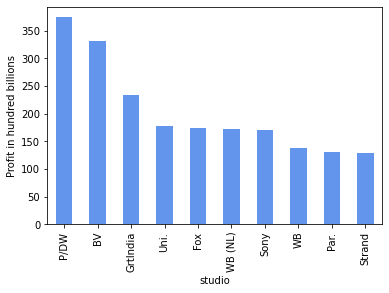

In [47]:
# Plot top 10
gross_budgets.groupby('studio')['profit'].mean().nlargest(10).plot(kind='bar', color='cornflowerblue', ylabel='Profit in hundred billions')

Text(0.5, 1.0, 'Top 10 Studios by Average Profit')

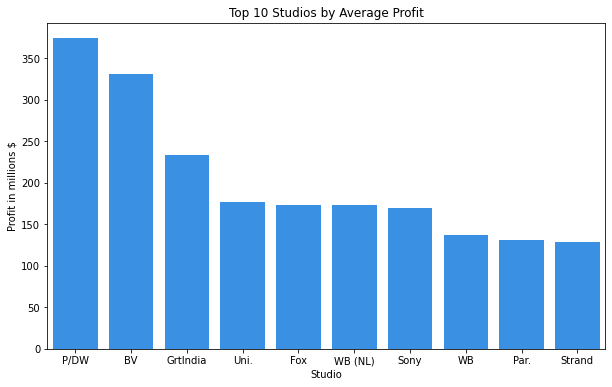

In [50]:
# Plot top 10 - Cleaned up
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='studio', y='profit', data=gross_budgets.groupby('studio')['profit'].mean().nlargest(10).reset_index(), color='dodgerblue')
plt.ylabel('Profit in millions $')
plt.xlabel('Studio')
plt.title('Top 10 Studios by Average Profit')